In [1]:
# зависимости
import urllib.request as req, json, numpy as np 
import itertools
# источник данных
meta_url = "https://metro.yandex.ru/api/get-scheme-metadata?id=1&lang=ru"
stations_url = "https://metro.yandex.ru/api/get-stations?id=1&lang=ru"

raw_meta = req.urlopen(meta_url).read()
with open("data/metro.meta.json", "wb") as f:
    f.write(raw_meta)
with open("data/metro.meta.json", "rb") as f:
    raw_meta = f.read()

raw_stations = req.urlopen(stations_url).read()
with open("data/metro.stations.json", "wb") as f:
    f.write(raw_stations)
with open("data/metro.stations.json", "rb") as f:
    raw_stations = f.read()
    
# метаинформация о переходах и пересадках
meta = json.loads(json.loads(raw_meta)["data"])
# станции
stat = json.loads(raw_stations)
print(stat['data'][:3], "...")

[{'id': 1, 'name': 'Бульвар Рокоссовского (Сокольническая линия)'}, {'id': 2, 'name': 'Черкизовская'}, {'id': 3, 'name': 'Преображенская площадь'}] ...


In [2]:
# приведём станции к виду словаря {id : название}
stations = dict((x["id"], x["name"]) for x in stat["data"])
# и обратный словарь
stations_reverse = dict((x["name"], x["id"]) for x in stat["data"])
# заведём матрицу смежности
metro = np.matrix([list([0] * len(stations)) for i in range(len(stations))])
# перегоны и переходы
links = meta["links"]
transfers = meta["transfers"]

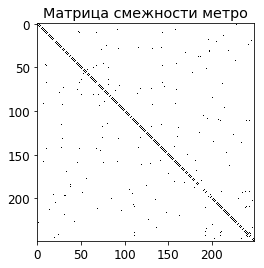

In [4]:
# заполним матрицу смежности
# станции нумеруются от 1, а строки в матрице от 0, поэтому -1
for id in links:
    link = links[id]
    start = link['fromStationId'] - 1
    end = link['toStationId'] - 1
    metro[start,end] = metro[end,start] = 1
    
for id in transfers:
    trans = transfers[id]['stationIds']
    # все пары неповторяющихся элементов
    for pair in itertools.combinations(trans, 2):
        start = pair[0] - 1
        end = pair[1] - 1
        metro[start,end] = metro[end,start] = 1

import numpy as np, math, matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

plt.imshow(metro, vmax=1, vmin=0, cmap="binary")
plt.title("Матрица смежности метро")
plt.show()

In [5]:
# используем матрицу смежности для подсчёта вариантов маршрутов
tx = np.matrix(metro)
_from, _to = "Шаболовская", "Полянка"
_from_id, _to_id = stations_reverse[_from] - 1, stations_reverse[_to] - 1
steps = 1
while tx[_from_id, _to_id] == 0:
    tx = tx * metro
    steps += 1
print("От", _from, "до", _to, "можно доехать за", steps, "шагов", tx[_from_id, _to_id], "способом")

От Шаболовская до Полянка можно доехать за 5 шагов 1 способом


In [6]:
# получить доступные станции, если state - это вектор состояния
def getConnected(state):
    pairs = zip(state.T.A[0], range(len(stations)))
    filtered = [x[1] for x in pairs if x[0]]
    return set([stations[i + 1] for i in filtered])

state = np.matrix(([[0] * len(stations)])).T
state[_from_id] = 1   # мы на Шаболовской
visited = getConnected(state)
steps = 0
while 'Полянка' not in visited:
    state = metro * state
    reached = getConnected(state) - visited
    visited |= reached
    steps += 1

print("От", _from, "до", _to, "можно доехать за", steps, "шагов")

От Шаболовская до Полянка можно доехать за 5 шагов


In [7]:
init_state = np.matrix(([[0] * len(stations)])).T
init_state[_from_id] = 1   # мы на Шаболовской

def getС(afterN, toWhere):
    n_steps = (metro ** afterN) * init_state
    last_step = metro[:,toWhere]
    return list(getConnected(n_steps) & getConnected(last_step))

m = []
dest = _to_id
track = [stations[_to_id + 1]]
steps = 5
while _from not in m:
    steps -= 1
    m = getС(steps, dest)
    track.append(m[0])
    dest = stations_reverse[m[0]] - 1   
print(*track[::-1], sep='\n')

Шаболовская
Октябрьская (Калужско-Рижская линия)
Октябрьская (Кольцевая линия)
Добрынинская
Серпуховская
Полянка
